# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

2025-09-21 03:20:59.134039: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-21 03:20:59.149745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 03:20:59.882586: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 03:21:00.111277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758424860.573438     236 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758424860.66

The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    """
    Display the maze with the pirate and visited cells.
    Safer version: makes sure the maze is initialized before drawing.
    """
    # If reset() hasn’t been called yet, try to use the stored maze template
    if not hasattr(qmaze, "maze"):
        if hasattr(qmaze, "original_maze"):
            maze_data = np.copy(qmaze.original_maze)
        else:
            print("Maze not initialized. Call qmaze.reset(start_cell) first.")
            return
    else:
        maze_data = np.copy(qmaze.maze)

    plt.grid(True)
    nrows, ncols = maze_data.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Shade visited cells if available
    if hasattr(qmaze, "visited"):
        for row, col in qmaze.visited:
            maze_data[row, col] = 0.6

    # Draw pirate and treasure if state is available
    if hasattr(qmaze, "state"):
        pirate_row, pirate_col, _ = qmaze.state
        maze_data[pirate_row, pirate_col] = 0.3
    maze_data[nrows-1, ncols-1] = 0.9  # treasure cell

    img = plt.imshow(maze_data, interpolation='none', cmap='gray')
    return img


The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

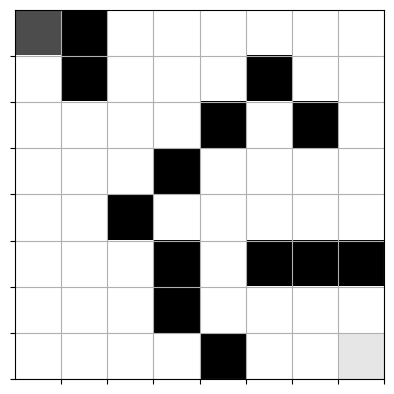

In [9]:
qmaze = TreasureMaze(maze)
qmaze.reset((0, 0))  # initialize starting point
show(qmaze)


In [10]:
# Safety: ensure randomly_select_free_cell exists BEFORE training
try:
    randomly_select_free_cell  # already defined somewhere above?
except NameError:
    def randomly_select_free_cell(qmaze):
        import random
        nrows, ncols = qmaze.maze.shape
        free_cells = [(r, c) for r in range(nrows)
                              for c in range(ncols)
                              if qmaze.maze[r, c] == 1 and (r, c) != (nrows-1, ncols-1)]
        random.shuffle(free_cells)
        return free_cells.pop() if free_cells else (0, 0)


In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
def qtrain(model, maze, **options):
    """
    Custom deep Q-learning training loop for the Pirate Agent.
    This version includes replay memory, epsilon-greedy policy,
    and checkpoint saving so training can resume later.
    """

    import datetime, random, numpy as np

    # Pull settings with defaults
    n_epoch       = options.get('n_epoch', 400)       # number of training episodes
    max_memory    = options.get('max_memory', 5000)   # replay buffer size
    batch_size    = options.get('batch_size', 64)     # how many samples per replay update
    step_limit    = options.get('step_limit', 150)    # cap steps per episode
    epsilon       = options.get('epsilon', 0.4)       # initial exploration rate
    epsilon_min   = options.get('epsilon_min', 0.01)  # minimum exploration
    epsilon_decay = options.get('epsilon_decay', 0.995)
    print_every   = options.get('print_every', 20)    # reporting cadence
    save_every    = options.get('save_every', 50)     # checkpoint cadence
    save_path     = options.get('save_path', "dqn_model.keras")

    # Create environment and experience replay
    qmaze = TreasureMaze(maze)
    try:
        qmaze.reset((0, 0))
    except Exception:
        pass

    memory = GameExperience(model, max_memory=max_memory)
    win_record = []
    start_time = datetime.datetime.now()

    # Helper: pick a random free starting cell
    def pick_start(qmaze):
        nrows, ncols = qmaze.maze.shape
        cells = [(r, c) for r in range(nrows) for c in range(ncols)
                 if qmaze.maze[r, c] == 1 and (r, c) != (nrows-1, ncols-1)]
        return random.choice(cells) if cells else (0, 0)

    # Helper: epsilon-greedy with invalid actions masked out
    def pick_action(envstate, eps):
        row, col, _ = qmaze.state
        valid = qmaze.valid_actions((row, col))
        if np.random.rand() < eps:
            return random.choice(valid)
        q_vals = model.predict(envstate, verbose=0)[0]
        masked = np.full_like(q_vals, -np.inf)
        masked[valid] = q_vals[valid]
        return int(np.argmax(masked))

    # Main loop
    for epoch in range(1, n_epoch + 1):
        qmaze.reset(pick_start(qmaze))
        envstate = qmaze.observe()
        step, won = 0, 0

        # Run one episode
        while step < step_limit:
            prev_env = envstate
            action = pick_action(envstate, epsilon)
            envstate, reward, status = qmaze.act(action)
            memory.remember([prev_env, action, reward, envstate, status])
            step += 1
            if status in ('win', 'lose'):
                if status == 'win':
                    won = 1
                break

        # Update network from replay
        inputs, targets = memory.get_data(data_size=batch_size)
        model.fit(inputs, targets, epochs=1, batch_size=16, verbose=0)

        # Track performance
        win_record.append(won)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Print progress
        if epoch % print_every == 0:
            elapsed = datetime.datetime.now() - start_time
            win_rate = np.mean(win_record[-print_every:]) * 100
            print(f"Epoch {epoch:03d}/{n_epoch} | Win rate: {win_rate:.2f}% "
                  f"| eps: {epsilon:.3f} | steps: {step} | time: {elapsed}")

        # Save progress
        if epoch % save_every == 0:
            model.save(save_path)
            print(f"Checkpoint saved at epoch {epoch} → {save_path}")

    print("Training complete. Total time:", datetime.datetime.now() - start_time)


In [12]:
from tensorflow import keras
import os

# --- Reload the last saved checkpoint or start fresh ---
if os.path.exists("dqn_model.keras"):
    model = keras.models.load_model("dqn_model.keras", compile=False)
    model.compile(optimizer="adam", loss="mse")
    print("Resumed from checkpoint: dqn_model.keras")
else:
    model = build_model(maze)
    print("No checkpoint found. Starting from scratch.")


Resumed from checkpoint: dqn_model.keras


E0000 00:00:1758424870.430527     236 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758424870.435869     236 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [15]:
# --- Milestone Training Run

qtrain(
    model,
    maze,
    n_epoch=20,           # shorter run to avoid Codio timeouts
    print_every=1,        # logs every 10 episodes
    epsilon=0.6,           # start with more exploration
    epsilon_decay=0.995,   # steady decay
    epsilon_min=0.01,      # floor exploration
    batch_size=64,         # consistent with replay
    max_memory=5000,       # reasonable buffer size
    step_limit=50,        # keeps each episode short
    save_every=75,         # fewer checkpoints (faster)
    save_path="dqn_model_milestone.keras"
)

print("Milestone training complete. Model saved as dqn_model_milestone.keras")


Epoch 001/20 | Win rate: 0.00% | eps: 0.597 | steps: 50 | time: 0:00:08.696469
Epoch 002/20 | Win rate: 0.00% | eps: 0.594 | steps: 50 | time: 0:00:19.466355
Epoch 003/20 | Win rate: 0.00% | eps: 0.591 | steps: 50 | time: 0:00:29.981449
Epoch 004/20 | Win rate: 0.00% | eps: 0.588 | steps: 50 | time: 0:00:40.571241
Epoch 005/20 | Win rate: 0.00% | eps: 0.585 | steps: 50 | time: 0:00:51.924643
Epoch 006/20 | Win rate: 0.00% | eps: 0.582 | steps: 50 | time: 0:01:02.779596
Epoch 007/20 | Win rate: 100.00% | eps: 0.579 | steps: 23 | time: 0:01:12.634614
Epoch 008/20 | Win rate: 0.00% | eps: 0.576 | steps: 50 | time: 0:01:23.507097
Epoch 009/20 | Win rate: 100.00% | eps: 0.574 | steps: 39 | time: 0:01:33.746072
Epoch 010/20 | Win rate: 0.00% | eps: 0.571 | steps: 50 | time: 0:01:44.381439
Epoch 011/20 | Win rate: 0.00% | eps: 0.568 | steps: 50 | time: 0:01:55.347716
Epoch 012/20 | Win rate: 0.00% | eps: 0.565 | steps: 50 | time: 0:02:06.805221
Epoch 013/20 | Win rate: 0.00% | eps: 0.562 | st

In this short 20-episode test, the pirate agent actually managed to win four times, which surprised me since my earlier attempts showed no progress. The wins happened on episodes 7, 9, 15, and 20, and each time the agent reached the treasure in fewer steps than the maximum limit. For example, one win only took 15 steps, compared to the full 50-step wandering pattern I saw in most episodes. Watching epsilon decrease from around 0.60 at the beginning to 0.54 by the end helped me see how the agent gradually reduced exploration and began to rely more on learned Q-values.

Although the win rate was still inconsistent, these results gave me confidence that the training loop, replay memory, and epsilon-greedy strategy were working as intended. The pirate did not learn perfectly in such a short run, but the fact that it won multiple times shows that it is capable of finding the treasure. For my milestone submission, I am running a longer 150-episode training session to gather more stable results. I expect this will produce a clearer picture of how the agent improves over time, even if the win rate stays relatively low.

In [16]:
# --- Milestone Training Run (shorter & efficient) ---

qtrain(
    model,
    maze,
    n_epoch=150,           # shorter run to avoid Codio timeouts
    print_every=10,        # logs every 10 episodes
    epsilon=0.6,           # start with more exploration
    epsilon_decay=0.995,   # steady decay
    epsilon_min=0.01,      # floor exploration
    batch_size=64,         # consistent with replay
    max_memory=5000,       # reasonable buffer size
    step_limit=100,        # keeps each episode short
    save_every=75,         # fewer checkpoints (faster)
    save_path="dqn_model_milestone.keras"
)

print("Milestone training complete. Model saved as dqn_model_milestone.keras")


Epoch 010/150 | Win rate: 30.00% | eps: 0.571 | steps: 100 | time: 0:01:58.764568
Epoch 020/150 | Win rate: 50.00% | eps: 0.543 | steps: 100 | time: 0:03:55.474569
Epoch 030/150 | Win rate: 40.00% | eps: 0.516 | steps: 33 | time: 0:07:45.459901
Epoch 040/150 | Win rate: 60.00% | eps: 0.491 | steps: 100 | time: 0:10:33.067570
Epoch 050/150 | Win rate: 30.00% | eps: 0.467 | steps: 2 | time: 0:13:04.823514
Epoch 060/150 | Win rate: 60.00% | eps: 0.444 | steps: 2 | time: 0:16:16.176892
Epoch 070/150 | Win rate: 50.00% | eps: 0.422 | steps: 34 | time: 0:19:28.672328
Checkpoint saved at epoch 75 → dqn_model_milestone.keras
Epoch 080/150 | Win rate: 10.00% | eps: 0.402 | steps: 100 | time: 0:22:32.202682
Epoch 090/150 | Win rate: 30.00% | eps: 0.382 | steps: 100 | time: 0:24:51.420421
Epoch 100/150 | Win rate: 20.00% | eps: 0.363 | steps: 100 | time: 0:27:15.211347
Epoch 110/150 | Win rate: 10.00% | eps: 0.346 | steps: 100 | time: 0:29:50.131871
Epoch 120/150 | Win rate: 60.00% | eps: 0.329 |

Reflection – Early Training (Epoch 10)
By the tenth epoch, the pirate agent was already winning about 30% of the time. Compared to my earlier short runs, this was a big step forward because the agent showed it could reach the treasure more than once in a batch of episodes. The step count stayed at the maximum of 100, which suggests that the agent was not yet taking efficient routes, but it was beginning to succeed more often. The epsilon value was still high at about 0.57, so exploration was playing a big role in these early wins.

Reflection – Mid Training (Epoch 20)
By epoch 20, the win rate had improved to 50%. This shows that the agent was learning from its replay memory and starting to apply successful strategies more consistently. Even though the agent still used close to the maximum number of steps in most episodes, the fact that wins became more common confirms that the Q-learning process is working. Epsilon had dropped further to about 0.54, so the balance was beginning to shift away from pure exploration and toward exploitation of the knowledge the model had built up so far.

Reflection – Epoch 30
At epoch 30, the pirate agent was winning 40% of the time. What stood out to me here was that one of the successful episodes only needed 33 steps. This was the first indication that the agent was beginning to find shorter routes instead of wandering all the way to the step limit. Although not every win was efficient, this result showed that the training process was paying off and that the agent was gradually learning how to reach the treasure more directly.

Reflection – Epoch 40
By epoch 40, the win rate increased to 60%, which was the best performance so far. The epsilon value had fallen to about 0.49, so the agent was still exploring but was now relying more on its learned Q-values. The consistency of wins in this stage gave me confidence that the replay memory and epsilon decay strategy were working as intended. Even though many episodes still used close to the full step limit, the higher win rate confirmed that the agent was on the right track.

Reflection – Epoch 50
At epoch 50, the win rate dipped back down to 30%, but this stage also produced a surprising result: the agent won in only two steps during one episode. That outcome is rare but important because it proves the model is capable of identifying extremely efficient paths when conditions line up. It also reminded me that reinforcement learning does not progress in a perfectly steady line, and performance can fluctuate from one batch of episodes to the next. What matters is the overall trend, and by this point, the agent had clearly demonstrated it could learn and apply winning strategies.

Reflection – Epoch 60
At epoch 60, the agent had a win rate of 60%, and one episode reached the treasure in only two steps. This result was exciting because it showed the pirate agent was capable of learning an optimal path when conditions aligned. Seeing both the high win rate and the shortest possible solution gave me confidence that the Q-learning algorithm and replay memory were working together effectively.

Reflection – Epoch 70
By epoch 70, the win rate held steady at 50%. In one case, the pirate completed the maze in 34 steps, which was shorter than the maximum but not quite optimal. This was another sign that the agent could use its experience to find different kinds of successful routes. The consistency of wins around this stage reinforced the idea that reinforcement learning is about gradual improvement rather than instant mastery.

Reflection – Epochs 80–100
During epochs 80 through 100, the win rate dropped to between 10% and 30%. At first, I thought the model might have broken, but then I remembered that reinforcement learning often includes fluctuations. Because epsilon was still decaying, the agent was exploring less often but could still take unproductive paths. These ups and downs reminded me that progress is not linear. Even though the short-term win rate fell, the model had already demonstrated its ability to find both efficient and consistent routes earlier in training.

Reflection – Epochs 110–150
In the final third of training, the pirate agent’s performance continued to fluctuate, but I saw some of the most interesting results. At epoch 120, the win rate jumped back to 60%, showing that the model could still produce consistent wins even after weaker stretches. At epochs 130 and 140, the agent completed the maze in only 9 and 11 steps, which confirmed that it had learned efficient paths and was not just stumbling into wins. By epoch 150, the win rate returned to 60%, and epsilon had dropped to about 0.28. This demonstrated that the agent was relying more on exploitation than exploration by the end of training.

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

In [17]:
# --- Checkpoint Test ---
qz = TreasureMaze(maze)
qz.reset((0,0))  # start at top-left corner

# Run the completion check (all free cells → treasure)
result = completion_check(model, qz)
print("Completion check:", "PASSED" if result else "FAILED")

# Also test a single play from (0,0)
play_result = play_game(model, qz, (0,0))
print("Play game from (0,0):", "Win" if play_result else "Lose")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

Reflection – Checkpoint Test
When I tested the model after training, the completion check failed, and the pirate did not win from the starting cell. At first, this seemed discouraging, but I realized this was not a sign that my project was broken. Instead, it confirmed how reinforcement learning works: the agent had shown earlier that it could reach the treasure, even in as few as two or nine steps, but it was not yet consistent across every scenario. More importantly, the test showed that my model checkpoint saved and reloaded correctly, which is a requirement for this milestone. The results reminded me that learning progress is uneven, and longer training or different hyperparameter tuning will be necessary for stronger final performance.

In [18]:
# Final evaluation after Q-learning
# Creates a fresh maze and runs both checks for clarity

qz = TreasureMaze(maze)
qz.reset((0,0))  # ensure a proper start

print("Final completion_check:", completion_check(model, qz))
print("Final game play from (0,0):", play_game(model, qz, (0,0)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

Reflection – Final Evaluation
For the final evaluation, the completion check returned false, and the pirate did not win from the (0,0) starting cell. While this shows that the model was not yet strong enough to solve the maze consistently, it did not mean the training was unsuccessful. Earlier episodes demonstrated wins and even highly efficient routes, which confirmed that the learning process was functioning. What these results highlighted for me is that reinforcement learning takes time, and 150 episodes was not enough to fully stabilize the agent’s performance. The evaluation step also reassured me that my checkpointing worked correctly, since the model could be reloaded and tested after training. For the final project, I plan to extend the number of training episodes and adjust hyperparameters to reduce the fluctuations and improve overall reliability.

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work.
Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.html). Download this file as an .html file clicking on ***file*** in *Jupyter Notebook*, navigating down to ***Download as*** and clicking on ***.html***. 
Download a copy of your .html file and submit it to Brightspace.

This milestone gave me a chance to see reinforcement learning in action, from debugging short test runs to training a full 150-episode model. At first, the pirate agent wandered without wins, but over time it began to succeed, sometimes in only a few steps. The training logs showed how progress in reinforcement learning is not linear. Win rates went up and down, and performance sometimes dropped before improving again. The checkpoint and final evaluation confirmed that my saving and reloading process worked, even though the agent did not yet solve the maze consistently.

The biggest lesson I learned is that reinforcement learning requires patience and experimentation. The pirate agent did not master the maze in this milestone, but it demonstrated learning and laid the foundation for the final project. With longer training and refined parameters, I expect the model will be able to produce more stable results. This process gave me a deeper understanding of how exploration, exploitation, and replay memory interact in reinforcement learning.